In [ ]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

# Step 1. 인물모드 직접 해 보기
- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- #pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

# Step1-1.인물 1명, 3명, 다수

## 1). 인물 1명 (나)

In [ ]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jun.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()


In [ ]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 


In [ ]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path) 
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용

In [ ]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

In [ ]:
# segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 
# output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [ ]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

- background, chair일부, 사람을 분류한 것 확인
- 하단 코드를 통해 실제로 맞는지 체크

In [ ]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [ ]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다(PixelLib 라이브러리에서 사용되는 컬러맵 생성 알고리즘)
# 이 컬러맵은 각 클래스나 레이블에 고유한 색상을 지정하기 위해 사용됩니다. 이를 통해 세그멘테이션 결과에서 각 클래스를 색상으로 시각화할 수 있습니다.
# 주목해야 할 것은 색상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
"""
	•colormap:
	•크기가 (256, 3)인 2D 배열로, 256개의 색상(RGB)을 저장하기 위한 배열입니다.
	•초기값은 모두 0.
	•각 행은 하나의 RGB 색상을 나타냅니다.
	•예: colormap[0] = [R, G, B].
"""
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력 RGB
"""
	•각 클래스 인덱스(0~255)에 대해 고유한 RGB 색상을 생성.
	•첫 20개의 색상을 출력:
•	클래스 0: [0, 0, 0] → 검정색.
•	클래스 1: [128, 0, 0] → 어두운 빨간색.
•	클래스 2: [0, 128, 0] → 어두운 초록색.
"""

In [ ]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

In [ ]:
seg_color = (128,128,192) # BGR로 바꿔주기
# 색상순서 변경 - colormap의 배열은 RGB 순이며 
# output의 배열은 BGR 순서로 채널 배치가 되어 있어서

In [ ]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
"""
segvalues, output = model.segmentAsPascalvoc(img_path) 
# segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 
# 분할 은 pacalvoc 데이터로 학습된 모델을 이용
"""

In [ ]:
print(seg_map.shape) 
plt.imshow(seg_map)
plt.show()

In [ ]:
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

*공부  
	•	output의 각 픽셀이 seg_color와 같은지 비교하여 불리언 배열 생성.  
	•	결과 배열 형태: (H, W, C), 각 채널에 대해 True/False.
    
    • np.all(..., axis=-1):
	•	채널 축(C) 기준으로 모든 값이 True인지 확인.
	•	결과는 (H, W) 형태의 2D 배열로 변환:
	•	True: 해당 픽셀이 seg_color와 일치.
	•	False: 해당 픽셀이 seg_color와 일치하지 않음.

In [ ]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

In [ ]:
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255
"""
	•seg_map: 사람이 있는 위치를 True(1)로, 배경은 False(0)로 나타낸 2D 배열.
	•astype(np.uint8):
	•seg_map은 불리언 타입(True, False)이므로 이를 8비트 정수로 변환.
	•* 255:
	•True → 255, False → 0으로 변환하여 이미지 데이터를 표현 가능.
"""


In [ ]:
# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
"""
	•cv2.applyColorMap:
	•2D 이진화 마스크(img_mask)에 색상맵을 적용하여 시각적으로 구분되는 컬러 마스크(color_mask) 생성.
	•COLORMAP_JET: 빨강, 노랑, 파랑 등의 색상을 포함하는 컬러맵.
	•결과:
	•사람이 있는 부분(255)은 컬러맵에 따라 색상으로 표현.
	•배경(0)은 기본 색상(보통 파랑)으로 표시.
"""


In [ ]:
# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)
# 0.0: 추가할 상수(이미지 밝기를 조정).

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
                           
"""
	•OpenCV는 기본적으로 BGR 형식으로 이미지를 처리하지만, Matplotlib은 RGB 형식으로 이미지를 표시.
	•cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB):
	•BGR 이미지를 RGB로 변환하여 올바르게 표시.
	•plt.show():
	•합성된 이미지를 출력.
"""                           


- 분할된 이미지를 실제로 값을 적용, 데이터에 적용시키기


In [ ]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요 : cv2.blur(img_orig, (13,13)) -> 25,25적용
img_orig_blur = cv2.blur(img_orig, (25,25))

# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB)) 
plt.show()

- #plt할때는 항상 cv2.cvtColor과 cv2.COLOR_BGR2RGB를 체크하자.

In [ ]:
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) #img_mask는 255 또는 0이었음 (마스크 기준)
"""
기존 •img_mask:
	•사람 영역을 255, 배경을 0으로 나타내는 이진화된 그레이스케일 마스크.

	•변환 원리:
그레이스케일 픽셀 값을 3개의 동일한 채널로 복제:
GRAY -> BGR = [GRAY,GRAY,GRAY]

"""

In [ ]:
# cv2.bitwise_not(): 이미지가 반전됩니다. 배경이 0 사람이 255 였으나
# 연산을 하고 나면 배경은 255 사람은 0입니다.
img_bg_mask = cv2.bitwise_not(img_mask_color) #배경이 255가 됨

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있습니다.
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 
# 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지고 배경만 남아요!
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # 배경만 살리기
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

-  과정을 진행하면서 사용한 변수들 정리 (헷갈리지 말것)
- (img_orig_blur) : 원본(사람,배경모두) 블러 처리된 이미지
- (img_bg_mask) : 배경은 255 사람은 0인
- (img_bg_blur) : 배경만 블러처리된 이미지
- (img_mask_color) : 사람255, 배경0인 이미지


In [ ]:
# np.where(조건, 참일때, 거짓일때)
# 세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 
# 아닌 영역은 블러된 이미지 값을 사용합니다.
# True과 False인 값을 각각 255과 0으로 바꿔줍니다
"""
img_mask = seg_map.astype(np.uint8) * 255
	•seg_map: 사람이 있는 위치를 True(255)로, 배경은 False(0)로 나타낸 2D 배열.
"""

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 마스킹 이미지를 기준으로, 255인 부분만 origin이미지를 넣고, 0인 부분엔 만들어둔 img_bg_blur 이미지를 넣는다 


In [ ]:
plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Result Image")
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

- 결과분석은 하단 step2 문제점 분석을 참조

## 2). 인물 4명 (루시밴드)

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/lucy.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

- 화질이 좋지 않아도 세그멘테이션을 잘 할까?? 시도해보자


In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path) 

In [ ]:
# segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 
# output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [ ]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

In [ ]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

- 무엇을 개로 판단했을까?
- 나머지 화분에 심은 식물 등을 발견한 것이 보임

In [ ]:
print('people', colormap[15]) #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
print('dog', colormap[12]) #개

In [ ]:
seg_color_people = (128,128,192) 
seg_color_dog = (128,0,64) #RGB -> BGR로 바꾸기
# 색상순서 변경
#colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서


In [ ]:
seg_map = np.all(output==seg_color_people , axis=-1) 
seg_map2 = np.all(output==seg_color_dog , axis=-1) 
seg_map3 = seg_map = np.all((output == seg_color_people) | (output == seg_color_dog), axis=-1)

In [ ]:
print(seg_map.shape) 
print(seg_map2.shape) 

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

plt.subplot(1, 2, 1) 
plt.title("person_seg")
plt.imshow(seg_map, cmap='gray')

plt.subplot(1, 2, 2) 
plt.title("dog_seg")
plt.imshow(seg_map2)

plt.tight_layout()  # 레이아웃 정리
plt.show()



- 모델에서 새로 알게 된 점 : 한 영역에 대해서(애매할시?) 2가지 클래스 모두 속하게끔 하는것 같다 (질문)
- 강아지는 잘못된 점을 알게됐으니, 사람만을 목표로 실험 진행 이어서하기

In [ ]:
img_show = img_orig.copy() #카피

img_mask = seg_map.astype(np.uint8) * 255 # 이미지 255, 배경0
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 적당한 색으로 바꿔주기

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 이미지, 배경 적당히 섞기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_orig_blur = cv2.blur(img_orig, (30,30)) #이미지 전체 블러 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
"""
기존 •img_mask:
	•사람 영역을 255, 배경을 0으로 나타내는 이진화된 그레이스케일 마스크.

	•변환 원리:
그레이스케일 픽셀 값을 3개의 동일한 채널로 복제:
GRAY -> BGR = [GRAY,GRAY,GRAY]

"""

img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwsie_not : 배경255, 사람0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # &연산 배경만255로, origin blur가 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Result Image")
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

- 결과분석은 하단 step2 문제점 분석을 참조

## 3). 인물 다수 (축구선수들)

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/socker.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path) 

plt.imshow(output)
plt.show()

In [ ]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [ ]:
print('people', colormap[15]) #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

In [ ]:
seg_color = (128,128,192) 
seg_map = np.all(output==seg_color_people , axis=-1) 

print(seg_map.shape) 
print(seg_map2.shape) 

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

plt.subplot(1, 2, 1) 
plt.title("person_seg")
plt.imshow(seg_map, cmap='gray')

plt.tight_layout()  # 레이아웃 정리
plt.show()


In [ ]:
img_show = img_orig.copy() #카피

img_mask = seg_map.astype(np.uint8) * 255 # 이미지 255, 배경0
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 적당한 색으로 바꿔주기

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 이미지, 배경 적당히 섞기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_orig_blur = cv2.blur(img_orig, (30,30)) #이미지 전체 블러 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Result Image")
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

- 결과분석은 하단 step2 문제점 분석을 참조

## Step1-2.개와 사람

In [ ]:
# 개와 사람, 고양이 여러마리 #colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람) 활용

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/dog&person.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
segvalues, output = model.segmentAsPascalvoc(img_path) 
plt.imshow(output)
plt.show()

In [ ]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [ ]:
print('people', colormap[15])
print('dog', colormap[12]) #개', colormap[15]) #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

In [ ]:
seg_color_people = (128,128,192) 
seg_color_dog = (128,0,64) #RGB -> BGR로 바꾸기

In [ ]:
seg_map = np.all(output==seg_color_people , axis=-1) 
seg_map2 = np.all(output==seg_color_dog , axis=-1) 

In [ ]:
print(seg_map.shape) 
print(seg_map2.shape) 

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

plt.subplot(1, 2, 1) 
plt.title("person_seg")
plt.imshow(seg_map, cmap='gray')

plt.subplot(1, 2, 2) 
plt.title("dog_seg")
plt.imshow(seg_map2)

plt.tight_layout()  # 레이아웃 정리
plt.show()



In [ ]:
img_show = img_orig.copy() #카피

img_mask = seg_map2.astype(np.uint8) * 255 # 이미지 255, 배경0
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) # 적당한 색으로 바꿔주기

img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) # 이미지, 배경 적당히 섞기

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_orig_blur = cv2.blur(img_orig, (10,10)) #이미지 전체 블러 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) # bitwsie_not : 배경255, 사람0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) # &연산 배경만255로, origin blur가 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) 

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Result Image")
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

## Step1-3.크로마키 배경 합성 (바다 배경)

In [ ]:
# Step 1-2 개 segmentation 참조

In [ ]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.png'  
img_sea = cv2.imread(img_path) 
print(img_sea.shape)
plt.imshow(cv2.cvtColor(img_sea, cv2.COLOR_BGR2RGB))
plt.show()

이미지 shape을 통해, 사이즈가 서로 일치하지 않음을 확인. img_concat 고려 사이즈 일치시켜보자

In [ ]:
print(img_mask_color.shape) # 강아지 mask

In [ ]:
img_sea_resized = cv2.resize(img_sea, (300, 200))  # (width, height) 순서 주의

In [ ]:
img_concat2 = np.where(img_mask_color==255, img_orig, img_sea_resized)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Problem Check")
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

# Step2.문제점 찾기

### Step1-1.인물 1명(나) 에서의 문제점
- 바탕을 0으로 두어, origin 이미지와 비교해보기

In [ ]:
img_concat2 = np.where(img_mask_color==255, img_orig, 0)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Problem Check")
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

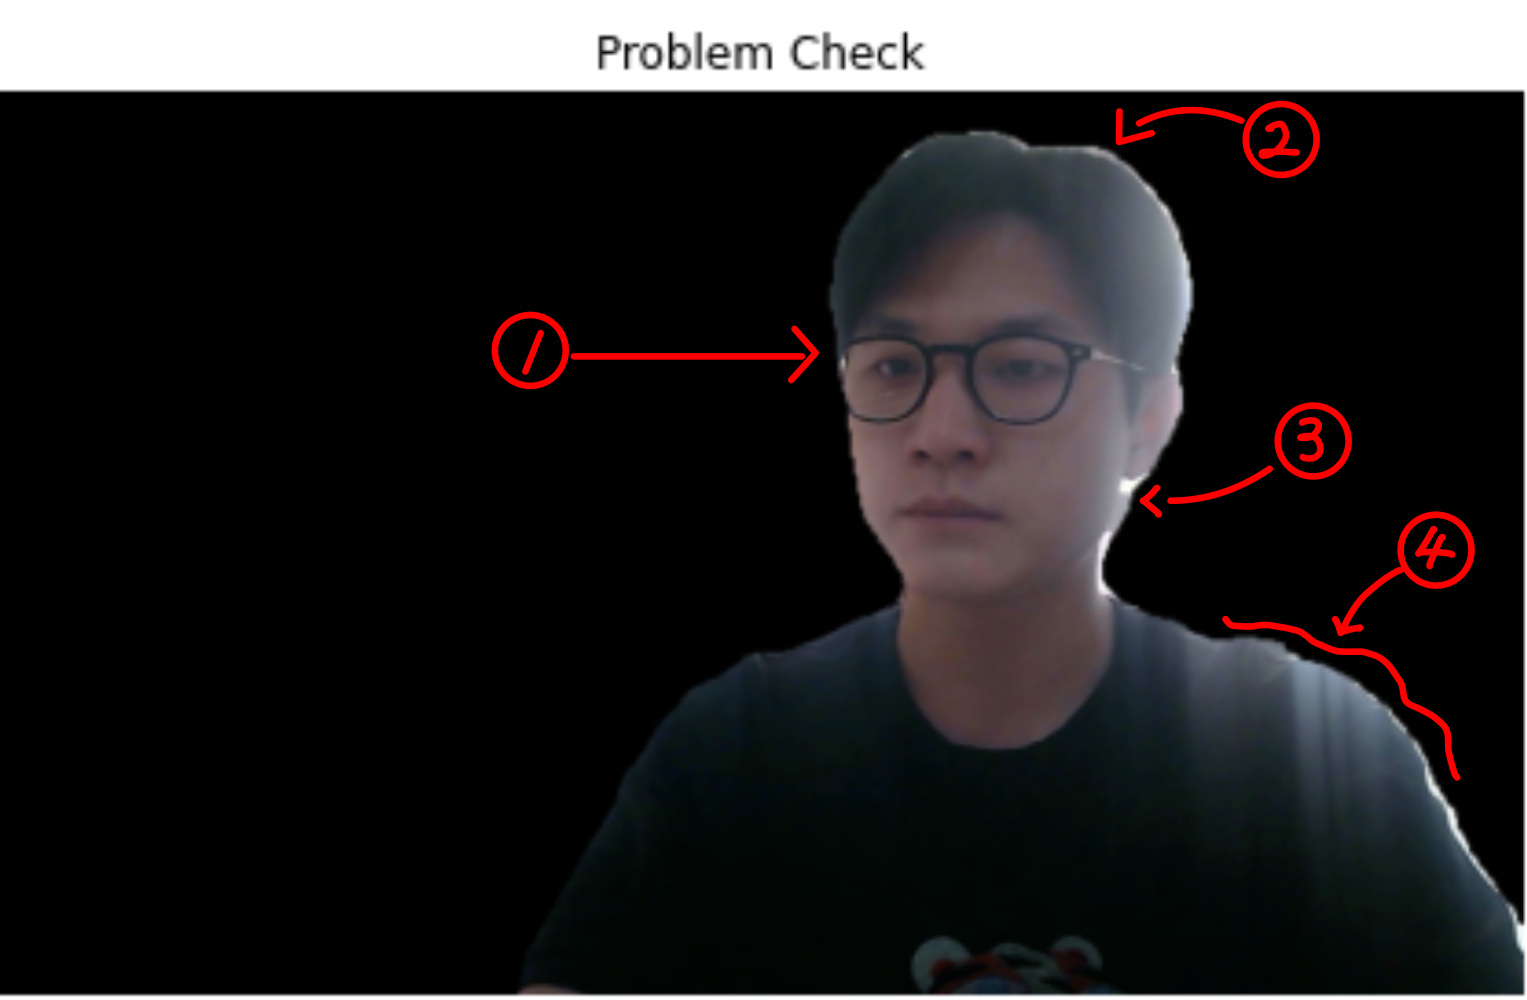
1. 좌측 안경 일부가 날아간 점이 보입니다.
2. 머리카락이 세세하게는 구현이 안됨 (조금 특별한 머리스타일들은 (그들의 개성)이 구현되지 않을 위험이 있지 않을까 싶습니다.
3. 귀와 목 사이 (의자가 보이는 부분)을 일부 디테일하게 구분하지 못한 점이 보입니다.
4. 옷의 경계부분을 보면 디테일하게 구분하지 못하는 것을 볼 수 있었습니다.

### Step1-1.  2).인물 4명(루시밴드) 에서의 문제점


In [ ]:
img_concat2 = np.where(img_mask_color==255, img_orig, 0)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Problem Check")
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

- 위 실험은 초기 목적이, 이미지의 해상도 자체가 흐린 이미지에 대해서도 segmentation을 잘할 수 있을까? 라는 궁금증에서 시작하였습니다.
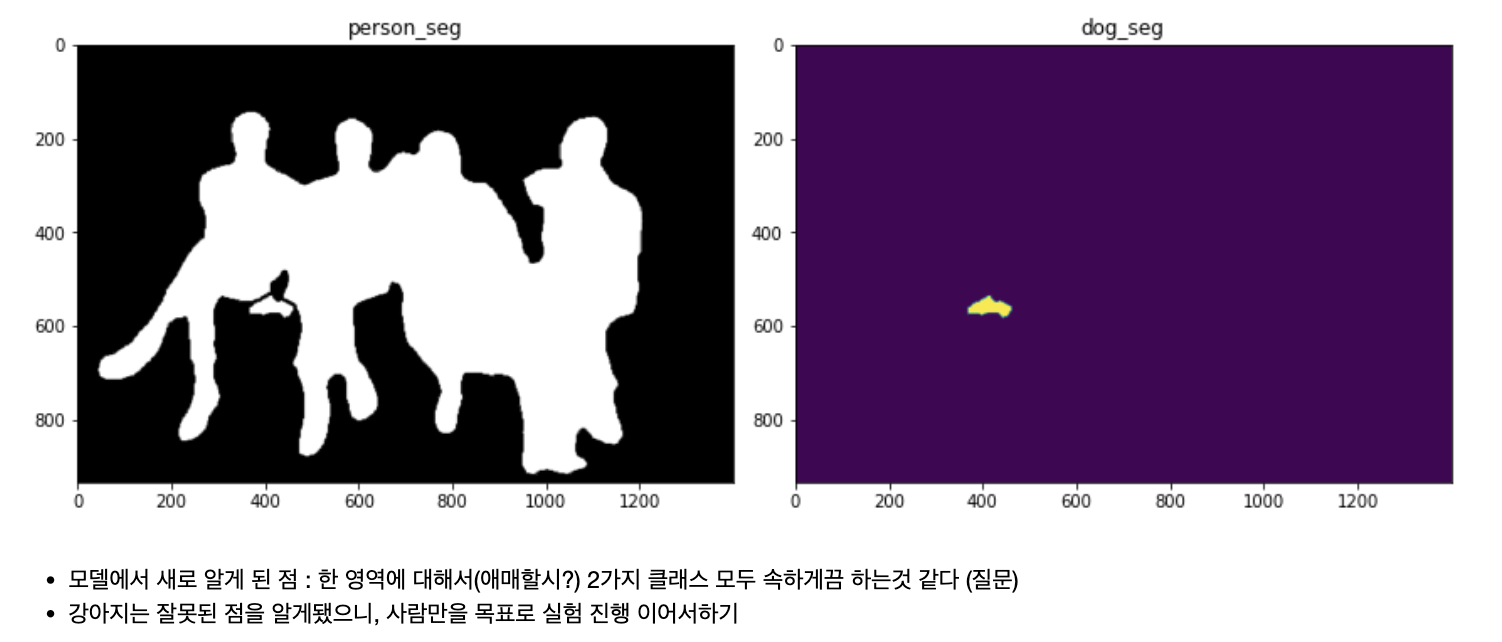 : 위 모델은 크게 4가지로 segmentation진행 (사람, 개, 소파, 화분)
1. 여기서 개를 무엇으로 보았는지 궁금하여 다음과 같이 seg_map을 살펴보았더니 한 영역에 대해 사람 또는 개 라고 함께 분류를 한 점을 확인할 수 있었습니다.
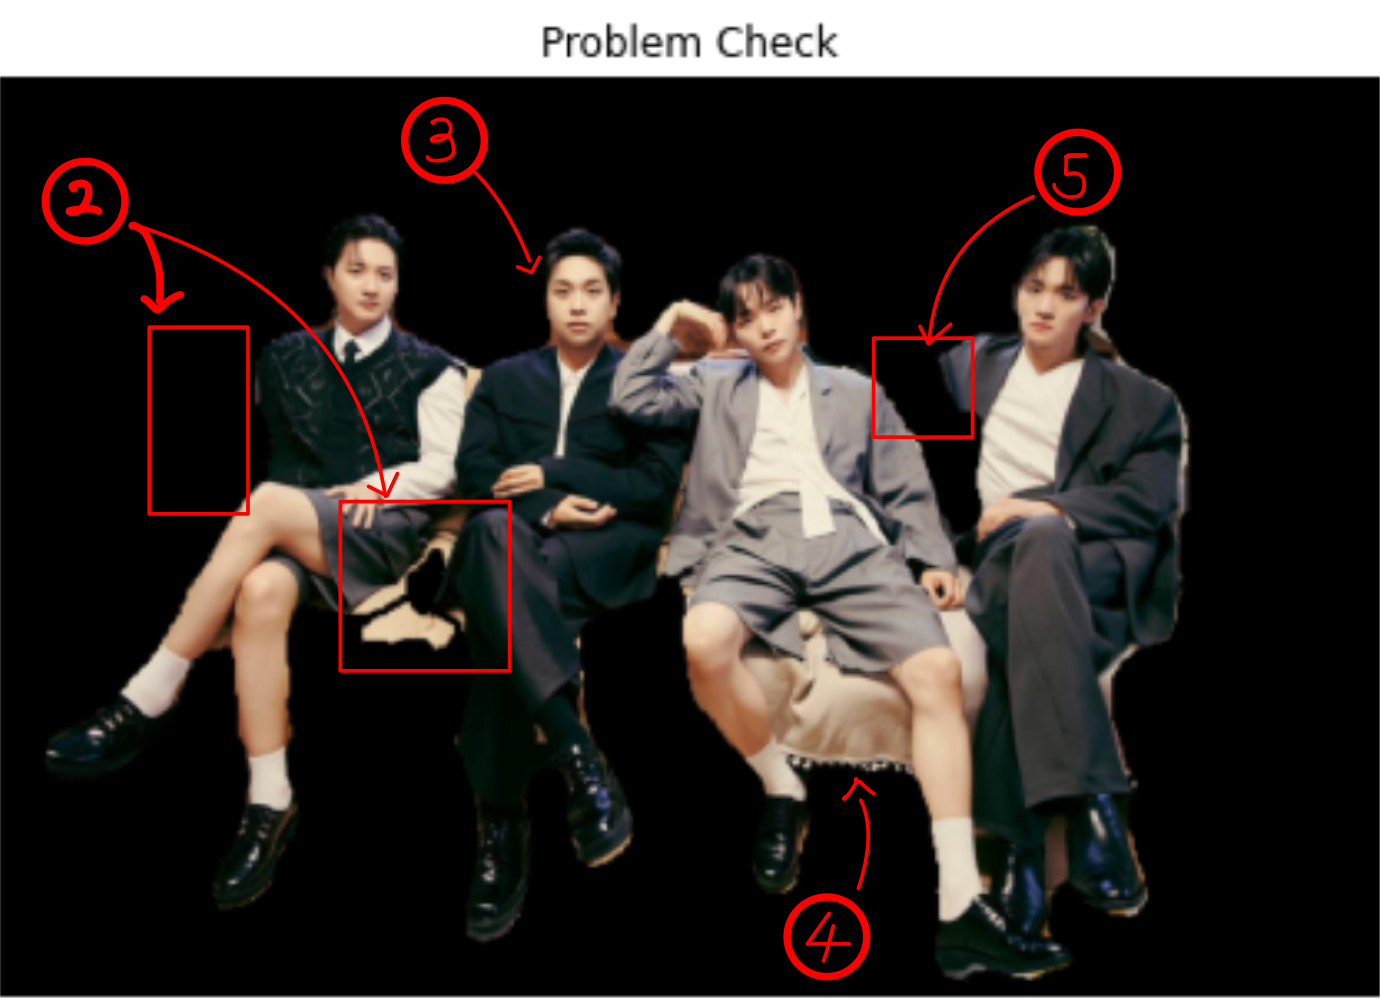
2. 사람분류의 관점으로 돌아가보면 좌측기준, 1번째사람의 팔이 분류가 안됐으며, 다리와 다리 사이, 1번째 사람과 2번째 사람 사이에 소파 배경이 많이 들어간 문제점을 확인 할 수 있습니다.
3. 2번째 사람은 머리스타일 귀 부분이 일부 분류되지 않는 문제점을 볼 수 있습니다.
4. 3번째 사람은 다리와 다리 사이의 소파배경을 사람으로 분류한 문제점을 볼수있습니다.
5. 4번째 사람또한 팔의 일부가 잘린 문제점을 볼수 있습니다.


### Step1-1.  3).인물 다수(축구팀) 에서의 문제점


In [ ]:
img_concat2 = np.where(img_mask_color==255, img_orig, 0)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Problem Check")
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

위 루시밴드에서 찾은 문제점과 유사한 문제점들이 도출됨을 확인할 수 있습니다.
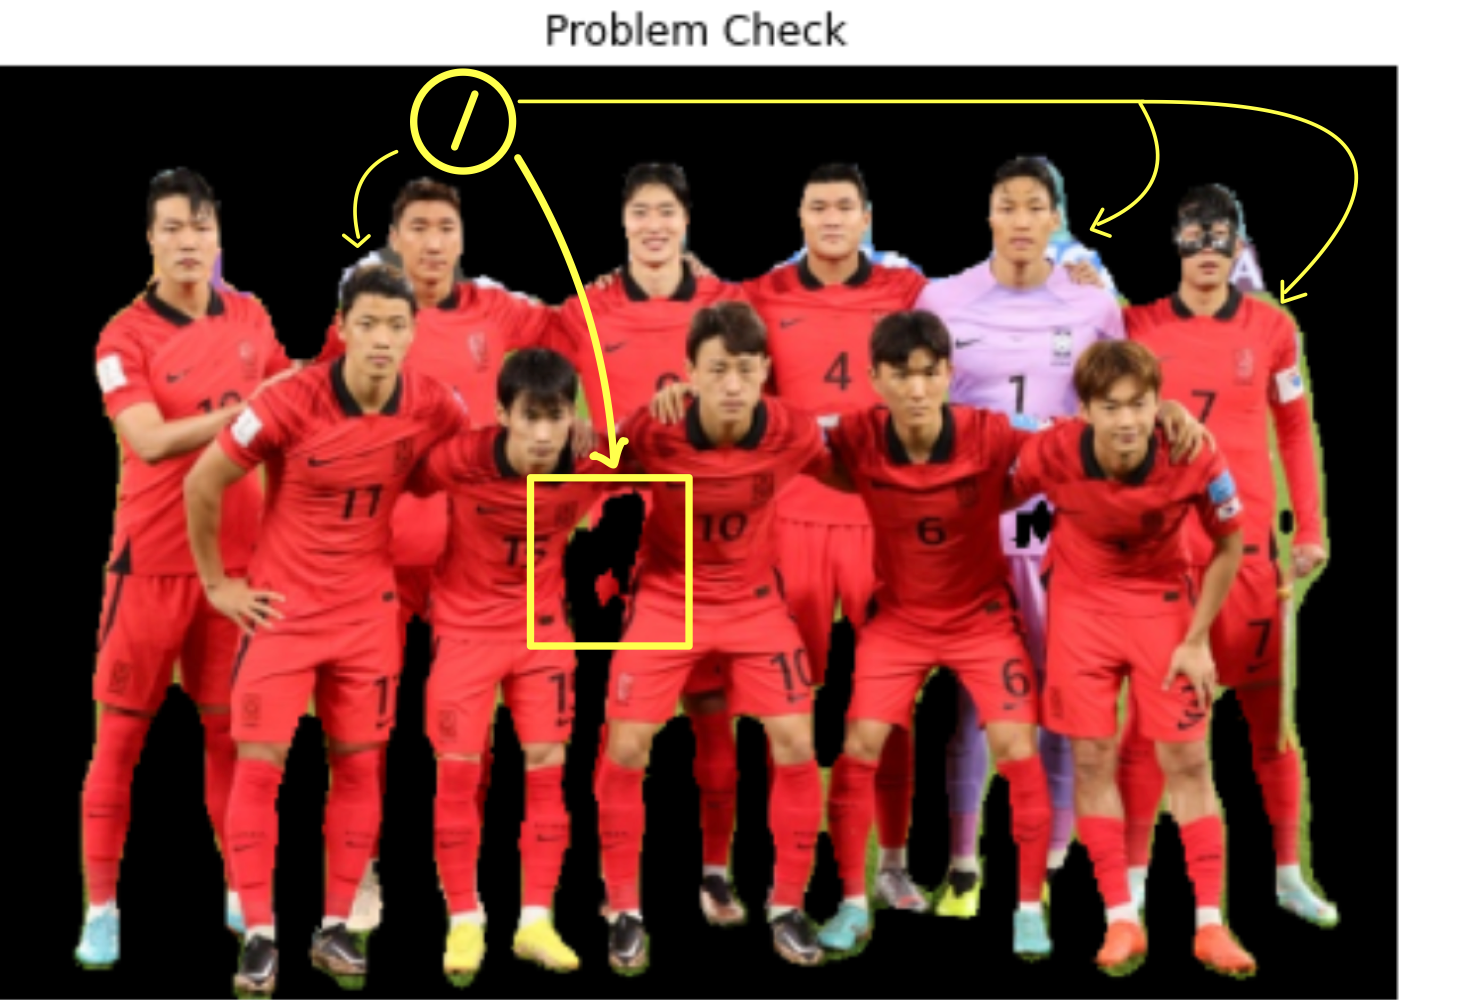
1. 가운데 선수 몸의 일부가 사라진다거나, 일부 뒷배경이 함께 들어가는 등의 문제점이 관찰 됩니다.
- Q.이미지의 화질이 문제점일 수도 있을까? -> 고화질/저화질 사진 2그룹을 통해 테스트 해볼 필요가 있음을 느꼈습니다.

### Step1-2.개와 사람에서 문제점

In [ ]:
img_concat2 = np.where(img_mask_color==255, img_orig, 0)
# plt.imshow(): 저장된 데이터를 이미지의 형식으로 표시한다.
# cv2.cvtColor(입력 이미지, 색상 변환 코드): 입력 이미지의 색상 채널을 변경
# cv2.COLOR_BGR2RGB: 원본이 BGR 순서로 픽셀을 읽다보니 
# 이미지 색상 채널을 변경해야함 (BGR 형식을 RGB 형식으로 변경)

plt.figure(figsize=(12, 6))  # 전체 출력 크기 설정

# 원본 이미지 출력
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 칸
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

# 결과 이미지 출력
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 칸
plt.title("Problem Check")
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))  # BGR → RGB 변환
plt.axis("off")  # 축 제거

plt.tight_layout()  # 레이아웃 정리
plt.show()

- 위 이미지는, 개와 사람에대한 클래스 구분을 잘 하였다고 생각했습니다. 하지만 상세히 보면, 개 이미지 일부가 명확하게 segmentation 되지 않음을 볼 수 있습니다.
1. 이미지 기준 좌측 눈 일부가 background 처리 된 점
2. 개의 테두리 주변 배경이 일부 함께 들어간 점
3. 개의 귀 부분 털에 자연스러움이 사라진점
을 들 수 있습니다.

## Step 3.해결 방법을 제안해 보기


- 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.

### 내용공부
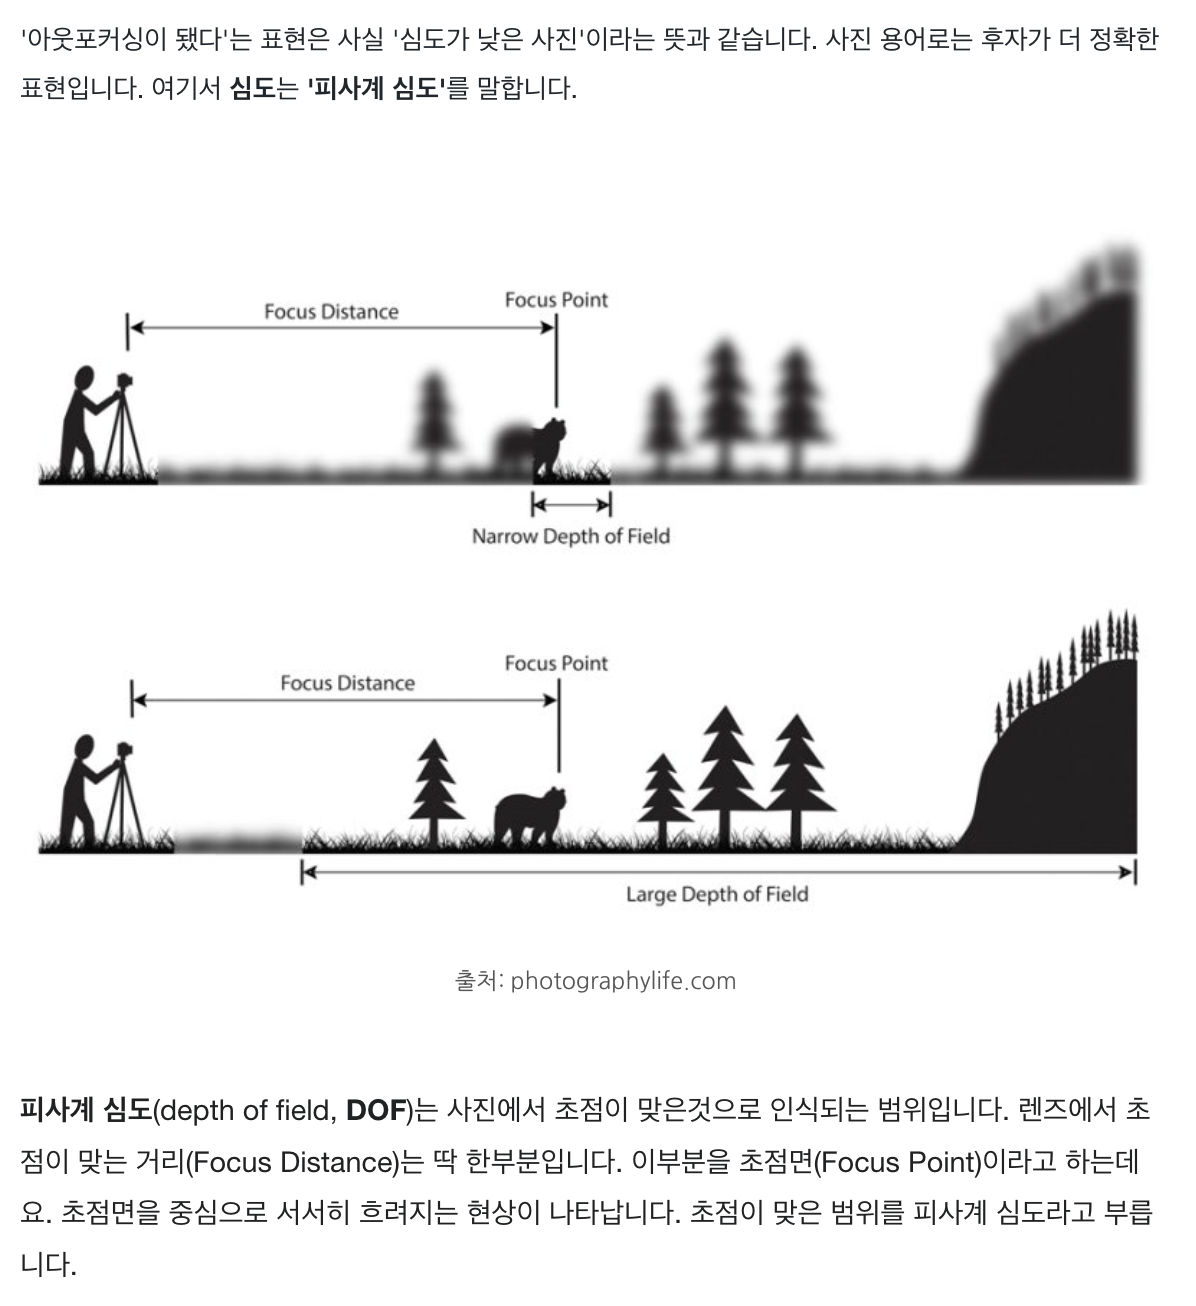
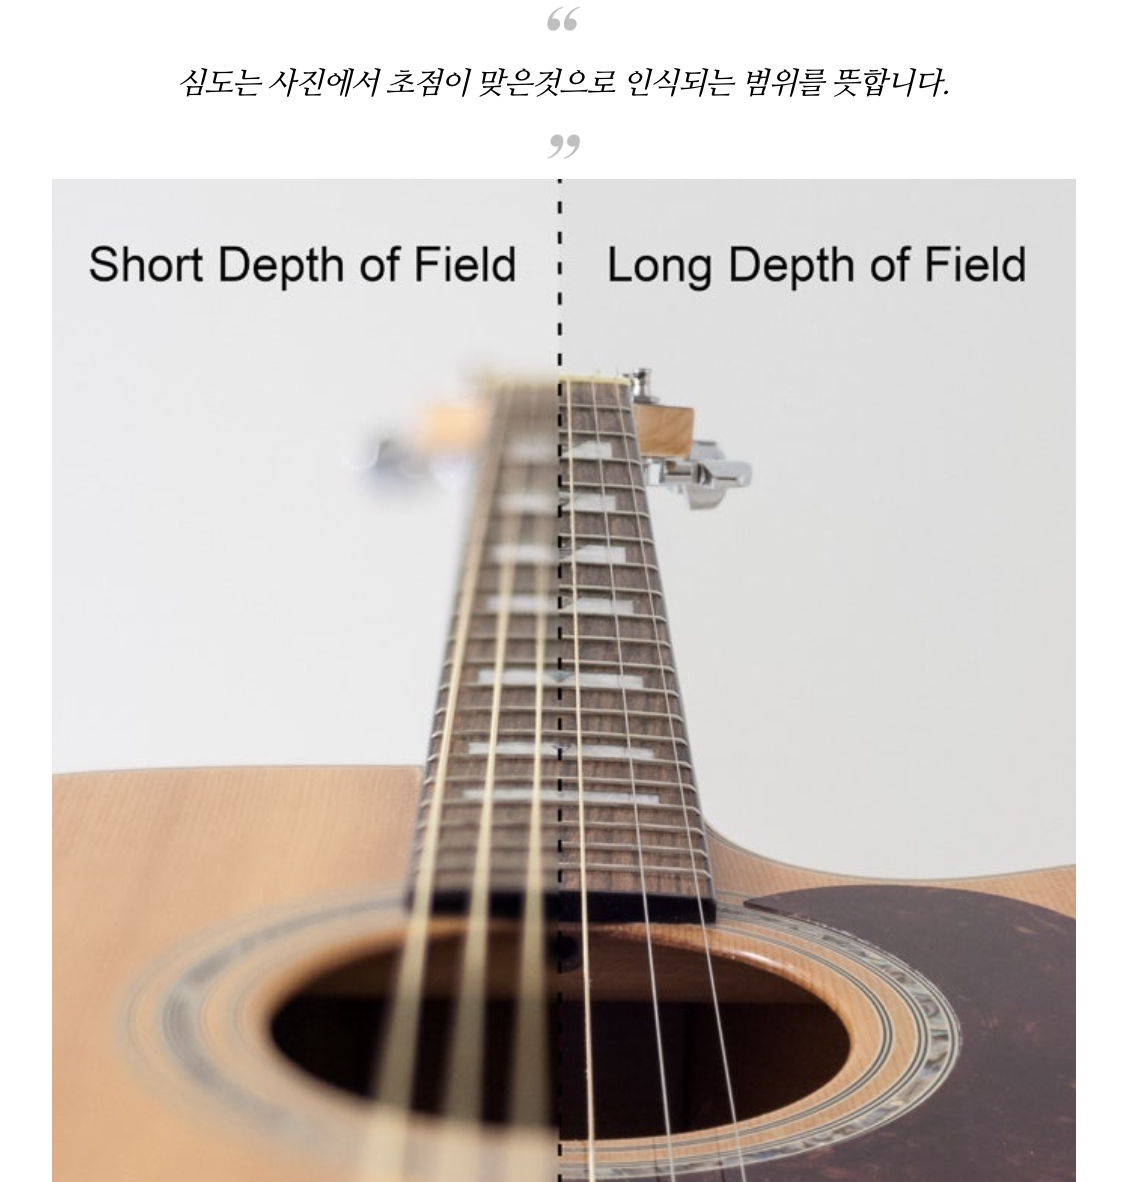
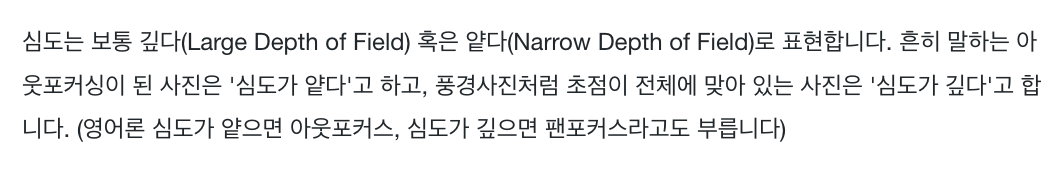


# Step 1-1 2) 루시밴드 문제점 개선
- 1~3차까지 실제 구현해보고자 하였지만, 라이브러리 설치에 문제가 많아,, 구현하지 못하였습니다.
- 하단에 문제점에 대해 개선방법에 대해 정리해보겠습니다.

# 4차 이미지 해상도 올리기(수업 이후 시도)

1. 상위 루시밴드 이미지는 구글 이미지로 200kb미만 용량의 저화질 이미지 입니다. 
2. 이미지 해상도를 높이면 픽셀 단위의 디테일이 증가하여 세그멘테이션 모델이 더 정확하게 객체와 배경을 구별할 수 있다고 생각합니다.
- 초해상도 기술(Super-Resolution)을 사용하면 저해상도 이미지의 경계선 및 세부 정보를 복원하여 세그멘테이션 품질을 향상시킬 수 있다고 합니다.  
--> 위와 같은 super-resolution 모델로는 Real-ESRGAN이 있습니다.  
- Real-ESRGAN은 고화질 이미지를 생성하면서도 노이즈 제거 성능이 뛰어나고, 실제 이미지에 적합한 초해상도 모델입니다.
3. 위 모델을 적용시 아래와 같은 효과를 얻을 수 있습니다.  
    1).	화질 개선:  
	Super-Resolution을 적용하면 원본 이미지의 디테일과 경계가 개선되어, 세그멘테이션 모델이 더 나은 결과를 낼 가능성이 높아집니다.  
	2).	경계 감지 개선:  
	저해상도 이미지에서는 경계가 뭉개지는 경우가 많지만, Super-Resolution 모델은 경계 디테일을 보존합니다.  
	3).	전처리-후처리 통합:  
	Real-ESRGAN으로 전처리 후, 세그멘테이션 결과를 CRF나 Edge Detection과 결합하면 더욱 세밀한 결과를 얻을 수 있습니다.  




# 1차 Post processing - CRF(conditional random fiedl) 알고리즘
CRF의 원리와 장점은 다음과 같습니다.  
원리

	•	CRF는 픽셀 간의 관계를 고려하여 세그멘테이션 결과를 후처리하는 기법입니다.
	•	세그멘테이션 결과의 연속성과 정확성을 높이기 위해 사용됩니다.
	•	Smoothness Prior: 인접 픽셀은 동일한 클래스로 분류될 가능성이 높다.
	•	Edge Preservation: 경계를 강조하여 서로 다른 클래스 간의 구분을 유지.

장점

	1.경계선 개선:
	세그멘테이션 결과에서 경계가 부정확하거나 뭉개진 경우, CRF를 적용하면 경계를 더 선명하게 만듭니다.
	2.세밀한 세그멘테이션:
	작은 객체나 복잡한 패턴을 포함하는 이미지에서도 픽셀 간의 의존성을 활용해 더 세밀한 세그멘테이션 가능.
	3.모델 독립적:
	CRF는 모델 출력 후 독립적으로 적용되므로 기존 모델을 변경하지 않고도 적용 가능.

In [ ]:
import sys
sys.path.append('/path/to/site-packages')  # pip show pydensecrf에서 확인한 Location 경로

In [ ]:
import pydensecrf.densecrf as dcrf
print("pydensecrf imported successfully!")

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax, create_pairwise_gaussian, create_pairwise_bilateral


In [ ]:
def apply_crf(orig_image, output_prob):
#orig_image: 원본 이미지로, 크기 (H, W, 3)의 배열입니다. 여기서 H와 W는 이미지의 높이와 너비, 3은 RGB 채널을 의미합니다.
#output_prob: 세그멘테이션 모델의 출력 확률 맵으로, 크기 (C, H, W)입니다. C는 클래스 수, H, W는 원본 이미지와 같은 크기입니다.


	H, W = orig_image.shape[:2]
	num_classes = output_prob.shape[0]
#num_classes: 세그멘테이션에서 사용할 클래스 수를 output_prob에서 추출합니다.

	d = dcrf.DenseCRF2D(W, H, num_classes)
#DenseCRF2D: DenseCRF는 이미지를 2D로 처리하는 CRF 구현체입니다.

	unary = unary_from_softmax(output_prob)
	d.setUnaryEnergy(unary)
#unary_from_softmax(output_prob):
#	Softmax 확률 맵에서 Unary 잠재 함수(unary potentials)를 생성합니다.
#	Unary 잠재 함수는 각 픽셀이 특정 클래스에 속할 확률을 나타냅니다.

#d.setUnaryEnergy(unary):
#	DenseCRF 객체에 unary 잠재 함수를 설정합니다.
#	이는 CRF가 픽셀별 확률 정보를 기반으로 동작하도록 합니다.

	d.addPairwiseGaussian(sxy=3, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

"""	•	addPairwiseGaussian: 픽셀의 위치 관계를 반영하는 쌍항(pairwise) 잠재 함수를 추가합니다.
	•	sxy=3: 공간적 거리 가우시안 커널의 표준편차(픽셀 단위).
	•	compat=3: 커널 강도(호환성 계수).
	•	kernel=dcrf.DIAG_KERNEL: 대각선 커널을 사용.
	•	normalization=dcrf.NORMALIZE_SYMMETRIC: 대칭 정규화.
	•	이 커널은 픽셀 간의 공간적 근접성을 기준으로 유사도를 계산하며, 가까운 픽셀은 같은 클래스로 분류되도록 유도합니다. """
	
	
	d.addPairwiseBilateral(sxy=50, srgb=13, rgbim=orig_image, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
"""	•	addPairwiseBilateral: 위치와 색상 정보를 모두 반영하는 쌍항 잠재 함수.
	•	sxy=50: 공간적 거리의 표준편차.
	•	srgb=13: 색상 차이의 표준편차.
	•	rgbim=orig_image: 원본 이미지의 RGB 정보를 입력.
	•	compat=10: 커널 강도.
	•	kernel 및 **normalization**은 위와 동일.
	•	이 커널은 색상 및 위치 정보를 결합하여 세그멘테이션 경계선을 정교하게 만듭니다. 예를 들어, 색상이 크게 다른 영역은 별도의 클래스로 분리됩니다."""
	
	
	Q = d.inference(5)
"""	•	d.inference(5):
	•	CRF 최적화를 통해 픽셀의 최적 클래스를 결정합니다.
	•	5: 반복 횟수. 더 많은 반복은 정교한 결과를 도출하지만 계산 시간이 증가합니다.
	•	Q:
	•	클래스별 확률을 반환합니다. 크기 (C, H*W)이며, 각 픽셀의 클래스별 확률이 저장됩니다."""

	result = np.argmax(Q, axis=0).reshape((H, W))
"""	•	np.argmax(Q, axis=0):
	•	각 픽셀에 대해 가장 높은 확률을 가지는 클래스를 선택합니다.
	•	.reshape((H, W)):
	•	결과를 (H, W) 형태로 변환하여 이미지와 동일한 크기의 세그멘테이션 결과를 생성합니다."""
	
	return result #CRF를 적용한 세그멘테이션 결과. 각필셀의 클래스가 저장된 배열


- 구현 실패

# 실패 3차 seg former
Seg former의 원리와 장점, 한계점은 다음과 같습니다.  
원리

	•SegFormer는 트랜스포머(Transformer) 기반의 세그멘테이션 모델로, 기존 CNN 기반 모델보다 더 강력한 성능을 제공합니다.
	•다중 해상도 피처를 추출하고, 트랜스포머의 전역적인 문맥 정보를 활용하여 세밀하고 정확한 세그멘테이션을 수행합니다.

장점

	1.다중 해상도 피처:
	서로 다른 해상도의 피처를 결합하여 작은 객체와 큰 객체 모두에 대해 세밀한 세그멘테이션이 가능.
	2.효율성:
	트랜스포머의 전역 문맥 정보 활용으로 복잡한 이미지에서도 높은 성능을 보임.
	3.경량 모델:
	실시간 처리도 가능하도록 경량화된 설계.
	4.최신 기술:
	ADE20k, Cityscapes 등의 주요 데이터셋에서 최첨단(SOTA) 성능 달성.

한계

	•GPU 메모리 사용량이 높을 수 있음.
	•모델 크기에 따라 학습 및 추론 속도가 느릴 수 있음.

In [ ]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. 모델 및 Feature Extractor 로드
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

# 2. 이미지 로드 및 전처리
image_path = "path/to/lucy_band.jpg"  # 루시밴드 이미지 경로
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

inputs = feature_extractor(images=image, return_tensors="pt")

# 3. 모델 추론
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits  # (batch_size, num_classes, height, width)

# 4. 세그멘테이션 결과 처리
segmentation = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

# 5. 시각화를 위한 RGB 변환
unique_classes = np.unique(segmentation)
segmentation_rgb = np.zeros((*segmentation.shape, 3), dtype=np.uint8)

# ADE20k의 클래스별 색상을 임의로 매핑
palette = np.random.randint(0, 255, (150, 3), dtype=np.uint8)
for cls in unique_classes:
    segmentation_rgb[segmentation == cls] = palette[cls]

# 6. 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmentation Result (SegFormer)")
plt.imshow(segmentation_rgb)
plt.axis("off")

plt.tight_layout()
plt.show()

# 실패2 Edge detection

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 원본 이미지 로드
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

# 2. Edge Detection
edges = cv2.Canny(img_gray, threshold1=50, threshold2=150)  # 경계 감지
_, mask_edges = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)  # 이진화

# 3. 경계 기반 객체 마스크 생성
# 경계를 확장하여 객체 내부 포함
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
mask_dilated = cv2.dilate(mask_edges, kernel, iterations=3)

# 4. 모델 기반 세그멘테이션 로드 및 결합 (선택 사항)
# 모델 세그멘테이션 결과와 Edge Detection 결합
seg_map = (model.segmentAsPascalvoc(img_path)[1] == [128, 128, 192]).astype(np.uint8) * 255  # 세그멘테이션 마스크
combined_mask = cv2.bitwise_or(seg_map, mask_dilated)

# 5. 배경 블러 처리 및 합성
img_orig_blur = cv2.GaussianBlur(img_orig, (31, 31), 0)  # 배경 블러 처리
combined_mask_bgr = cv2.cvtColor(combined_mask, cv2.COLOR_GRAY2BGR)  # BGR로 변환
img_bg_mask = cv2.bitwise_not(combined_mask_bgr)  # 배경 영역 마스크
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)  # 블러 배경 생성
img_concat = np.where(combined_mask_bgr == 255, img_orig, img_bg_blur)  # 최종 합성

# 6. 시각화
plt.figure(figsize=(12, 8))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Edge Detection")
plt.imshow(mask_dilated, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Final Result")
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print("seg_map shape:", seg_map.shape)
print("mask_dilated shape:", mask_dilated.shape)

In [ ]:
print("seg_map dtype:", seg_map.dtype)
print("mask_dilated dtype:", mask_dilated.dtype)

In [ ]:
# 모델 기반 세그멘테이션 결과 생성
seg_map = (model.segmentAsPascalvoc(img_path)[1] == [128, 128, 192]).astype(np.uint8) * 255  # 사람 마스크

# Edge Detection 결과 크기 조정
mask_dilated_resized = cv2.resize(mask_dilated, (seg_map.shape[1], seg_map.shape[0]), interpolation=cv2.INTER_NEAREST)

# 데이터 타입 맞추기
seg_map = seg_map.astype(np.uint8)
mask_dilated_resized = mask_dilated_resized.astype(np.uint8)

# 세그멘테이션 결과와 Edge Detection 결합
combined_mask = cv2.bitwise_or(seg_map, mask_dilated_resized)

In [ ]:
mask_dilated_resized = cv2.resize(mask_dilated, (seg_map.shape[1], seg_map.shape[0]), interpolation=cv2.INTER_NEAREST)

In [ ]:
seg_map = seg_map.astype(np.uint8)
mask_dilated_resized = mask_dilated_resized.astype(np.uint8)

In [ ]:
combined_mask = cv2.bitwise_or(seg_map, mask_dilated_resized)